In [1]:
import numpy as np
import math
from scipy.sparse import coo_matrix, linalg, random
import matplotlib.pyplot as plt
import time
from timeit import timeit

## Defining Matrix functions

In [2]:
def make_matrix(N):
    A = np.zeros(((N+1)**2, (N+1)**2))
    b = np.zeros((N+1)**2)

    h = 1/N

    for i in range(N+1):
        A[i, i] = 1
        b[i] = 0
    for i in range(N**2+N, (N+1)**2):
        A[i,i] = 1
        b[i] = 0
    for i in range(N + 1, N**2+N, N+1):
        A[i,i] = 1
        b[i] = 0
    for i in range(2* N + 1, (N+1)**2-1, N+1):
        A[i,i] = 1
        b[i] = 0
    for i in range(1, N):
        for j in range(1, N):
            index = j * (N+1) + i
            A[index,index] = 4/h**2
            A[index,j * (N+1) + i-1] = -1/h**2
            A[index,(j-1) * (N+1) + i] = -1/h**2
            A[index,j * (N+1) + i+1] = -1/h**2
            A[index,(j+1) * (N+1) + i] = -1/h**2
            b[index] = 1
    return A, b

In [3]:
def make_matrix_sparse(N):
    rows = []
    cols = []
    data = []
    b = np.zeros((N+1)**2)

    h = 1/N

    for i in range(N+1):
        rows.append(i)
        cols.append(i)
        data.append(1.0)
        b[i] = 0
    for i in range(N**2+N, (N+1)**2):
        rows.append(i)
        cols.append(i)
        data.append(1.0)
        b[i] = 0
    for i in range(N + 1, N**2+N, N+1):
        rows.append(i)
        cols.append(i)
        data.append(1.0)
        b[i] = 0
    for i in range(2* N + 1, (N+1)**2-1, N+1):
        rows.append(i)
        cols.append(i)
        data.append(1.0)
        b[i] = 0
    for i in range(1, N):
        for j in range(1, N):
            index = j * (N+1) + i
            rows += [index, index, index, index, index]
            cols += [index, j * (N+1) + i-1, (j-1) * (N+1) + i, j * (N+1) + i+1, (j+1) * (N+1) + i]
            data += [4/h**2, -1/h**2, -1/h**2, -1/h**2, -1/h**2]
            b[index] = 1

    rows = np.array(rows)
    cols = np.array(cols)
    data = np.array(data)
    # Note: The error we saw in lectures was in the next line: data, rows, and cols in the wrong order
    A = coo_matrix((data, (rows, cols)), ((N+1)**2, (N+1)**2))
    return A, b

In [15]:
A, b = make_matrix(2)
A2, b2 = make_matrix_sparse(2)
A2 = A2.tocsr() #A2 doesnt have to be converted into CSR format but it is more efficient

In [5]:
u = np.linalg.solve(A,b)

u2 = linalg.spsolve(A2, b2)
assert np.allclose(u, u2)

## How much memory?


In [52]:
N = 20
size = 1000
sizes = np.logspace(0.4,np.log10(size),num=N, dtype=int)
store = np.zeros((N,2))

for i in range(N):
    a, a2 = make_matrix(i+1)
    b = coo_matrix(a)
    store[i,0] = a.nbytes
    store[i,1] = b.row.nbytes + b.col.nbytes + b.data.nbytes
store = store/1e3 

Text(0.5, 0, 'Size')

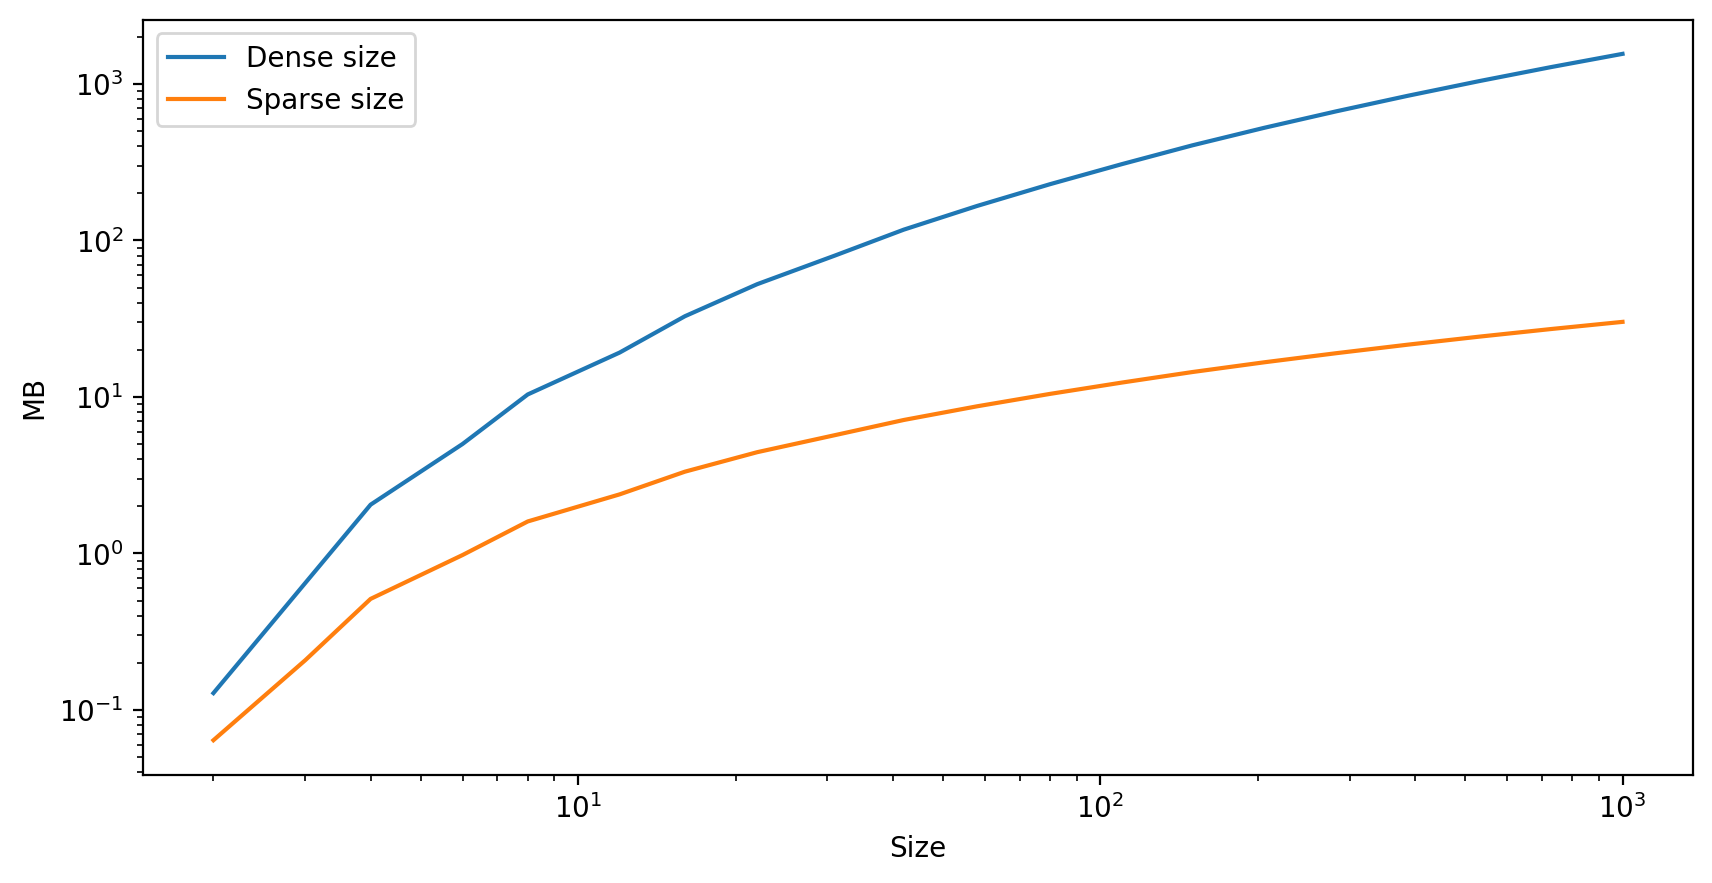

In [53]:
plt.figure(figsize=(10,5), dpi=200)
plt.plot(sizes, store[:,0], label='Dense size')
plt.plot(sizes, store[:,1], label='Sparse size')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylabel('MB')
plt.xlabel('Size')

## How much time?

In [9]:
x=0
for i in range(1000):
    start = time.time()
    x += i
    end = time.time()
    hi = end - start
    
print(hi)

9.5367431640625e-07


In [62]:
# LIL, DIA, DOK, and BSR

N = 50
size = 100000
sizes = np.logspace(0.4,np.log10(size),num=N, dtype=int)
store = np.zeros((N,8))
num_repeats = 10

for i in range(N):
    A, vector = make_matrix(i+1)
    A2 = coo_matrix(A)
    A3 = A2.tocsr()
    A4 = A2.tocsc()
    A5 = A2.tolil()
    A6 = A2.todia()
    A7 = A2.todok()
    A8 = A2.tobsr()

    store[i,0] = timeit(lambda: np.linalg.solve(A, vector),number = num_repeats)
    store[i,1] = timeit(lambda: linalg.spsolve(A2, vector),number = num_repeats)
    store[i,2] = timeit(lambda: linalg.spsolve(A3, vector),number = num_repeats)
    store[i,3] = timeit(lambda: linalg.spsolve(A4, vector),number = num_repeats)
    store[i,4] = timeit(lambda: linalg.spsolve(A5, vector),number = num_repeats)
    store[i,5] = timeit(lambda: linalg.spsolve(A6, vector),number = num_repeats)
    store[i,6] = timeit(lambda: linalg.spsolve(A7, vector),number = num_repeats)
    store[i,7] = timeit(lambda: linalg.spsolve(A8, vector),number = num_repeats)
    

/Users/harvey/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


Text(0.5, 0, 'Size (N)')

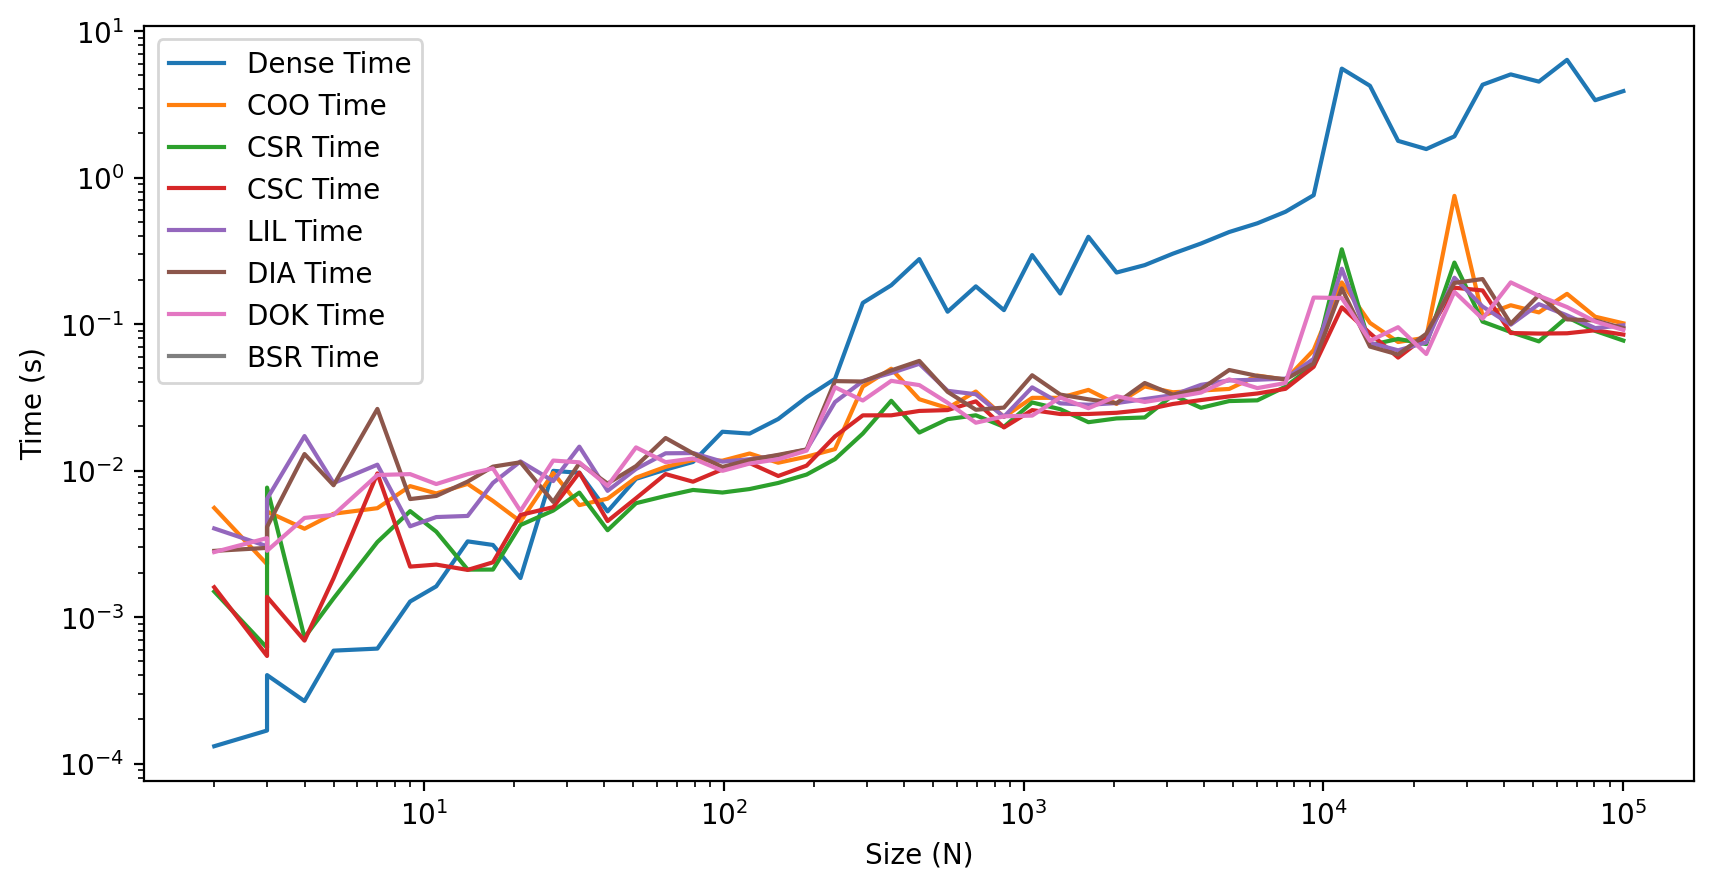

In [63]:
plt.figure(figsize=(10,5), dpi=200)
plt.plot(sizes, store[:,0], label='Dense Time')
plt.plot(sizes, store[:,1], label='COO Time')
plt.plot(sizes, store[:,2], label='CSR Time')
plt.plot(sizes, store[:,3], label='CSC Time')
plt.plot(sizes, store[:,4], label='LIL Time')
plt.plot(sizes, store[:,5], label='DIA Time')
plt.plot(sizes, store[:,6], label='DOK Time')
plt.plot(sizes, store[:,7], label='BSR Time')

plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylabel('Time (s)')
plt.xlabel('Size (N)')

## How much memory for different formats?

In [77]:
print(A5)
print(A5.data)
print(A5.values)

  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
[list([1.0]) list([1.0]) list([1.0]) list([1.0])]


AttributeError: values not found

In [83]:

print(A)

[[0.         0.         0.66114566 0.57459314 0.96133692 0.0301587
  0.14624414 0.07112237 0.         0.28217935]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.12133369
  0.         0.         0.         0.        ]
 [0.         0.         0.59041383 0.         0.66937044 0.6315708
  0.9039403  0.         0.         0.45370336]
 [0.21991039 0.15172247 0.         0.         0.69835727 0.
  0.72107092 0.         0.         0.        ]
 [0.03202054 0.         0.         0.01091109 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.63828061 0.38893504 0.34828299 0.18292746
  0.         0.62100676 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.47792956 0.         0.        ]
 [0.         0.         0.48421926 0.4781725  0.         0.4456006
  0.         0.         0.26690551 0.        ]


In [104]:
M = 20
size = 10
num_vals = np.linspace(0.01,0.9,num=M)
store4 = np.zeros((N,4))

for i in range(M):
    A = random(size,size,format='dense', density = num_vals[i])
    A2 = coo_matrix(A)
    A3 = A2.tocsr()
    A4 = A2.tocsc()
    #A5 = A2.tolil()
    #A6 = A2.todia()
    #A7 = A2.todok()
    #A8 = A2.tobsr()
    
    
    store4[i,0] = A.nbytes
    store4[i,1] = A2.row.nbytes + A2.col.nbytes + A2.data.nbytes
    store4[i,2] = A3.data.nbytes + A3.indices.nbytes + A3.indptr.nbytes
    store4[i,3] = A4.data.nbytes + A4.indices.nbytes + A4.indptr.nbytes
    #store4[i,4] = A5.data.nbytes + A5.indices.nbytes + A5.indptr.nbytes
    #store4[i,5] = A6.data.nbytes + A6.indices.nbytes + A6.indptr.nbytes
    #store4[i,6] = A7.data.nbytes + A6.indices.nbytes + A7.indptr.nbytes
    #store4[i,7] = A8.data.nbytes + A7.indices.nbytes + A8.indptr.nbytes

Text(0.5, 0, 'Proportion of cells filled')

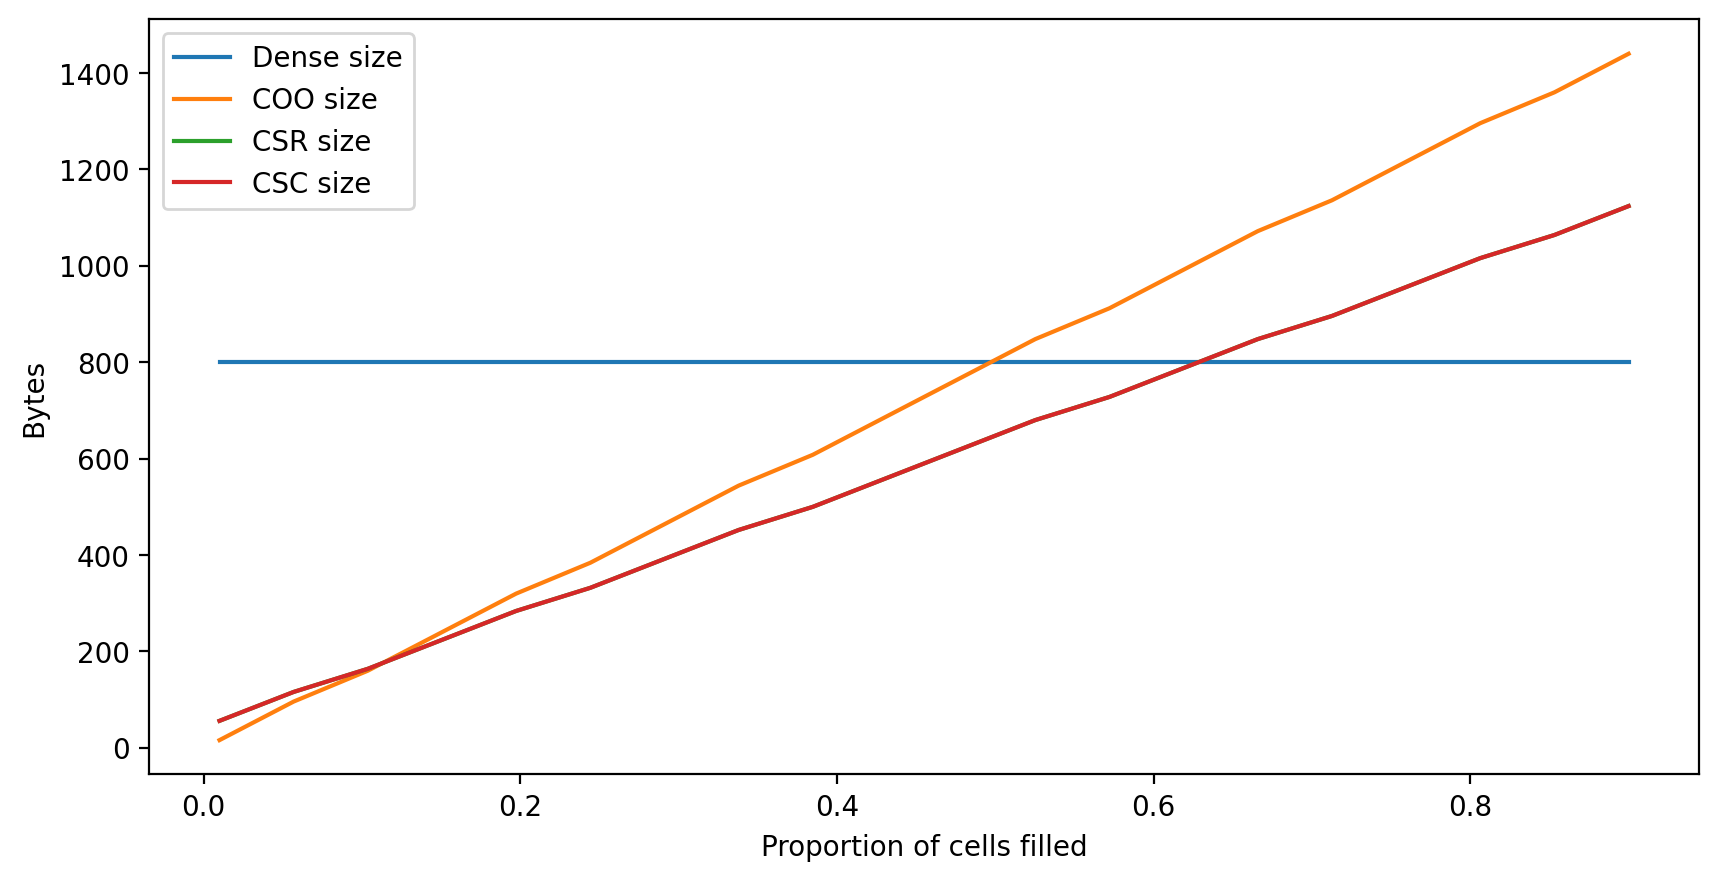

In [107]:
plt.figure(figsize=(10,5), dpi=200)
plt.plot(num_vals, store4[:,0], label='Dense size')
plt.plot(num_vals, store4[:,1], label='COO size')
plt.plot(num_vals, store4[:,2], label='CSR size')
plt.plot(num_vals, store4[:,3], label='CSC size')
#plt.plot(num_vals, store4[:,4], label='LIL size')
#plt.plot(num_vals, store4[:,5], label='DIA size')
#plt.plot(num_vals, store4[:,6], label='DOK size')
#plt.plot(num_vals, store4[:,7], label='BSR size')
#plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.ylabel('Bytes')
plt.xlabel('Proportion of cells filled')

In [109]:
M = 20
size = 40
num_vals = np.linspace(0.01,0.9,num=M)
store4 = np.zeros((N,4))

for i in range(M):
    A = random(size,size,format='dense', density = num_vals[i])
    A2 = coo_matrix(A)
    A3 = A2.tocsr()
    A4 = A2.tocsc()
    #A5 = A2.tolil()
    #A6 = A2.todia()
    #A7 = A2.todok()
    #A8 = A2.tobsr()
    
    
    store4[i,0] = A.nbytes
    store4[i,1] = A2.row.nbytes + A2.col.nbytes + A2.data.nbytes
    store4[i,2] = A3.data.nbytes + A3.indices.nbytes + A3.indptr.nbytes
    store4[i,3] = A4.data.nbytes + A4.indices.nbytes + A4.indptr.nbytes
    #store4[i,4] = A5.data.nbytes + A5.indices.nbytes + A5.indptr.nbytes
    #store4[i,5] = A6.data.nbytes + A6.indices.nbytes + A6.indptr.nbytes
    #store4[i,6] = A7.data.nbytes + A6.indices.nbytes + A7.indptr.nbytes
    #store4[i,7] = A8.data.nbytes + A7.indices.nbytes + A8.indptr.nbytes

Text(0.5, 0, 'Proportion of cells filled')

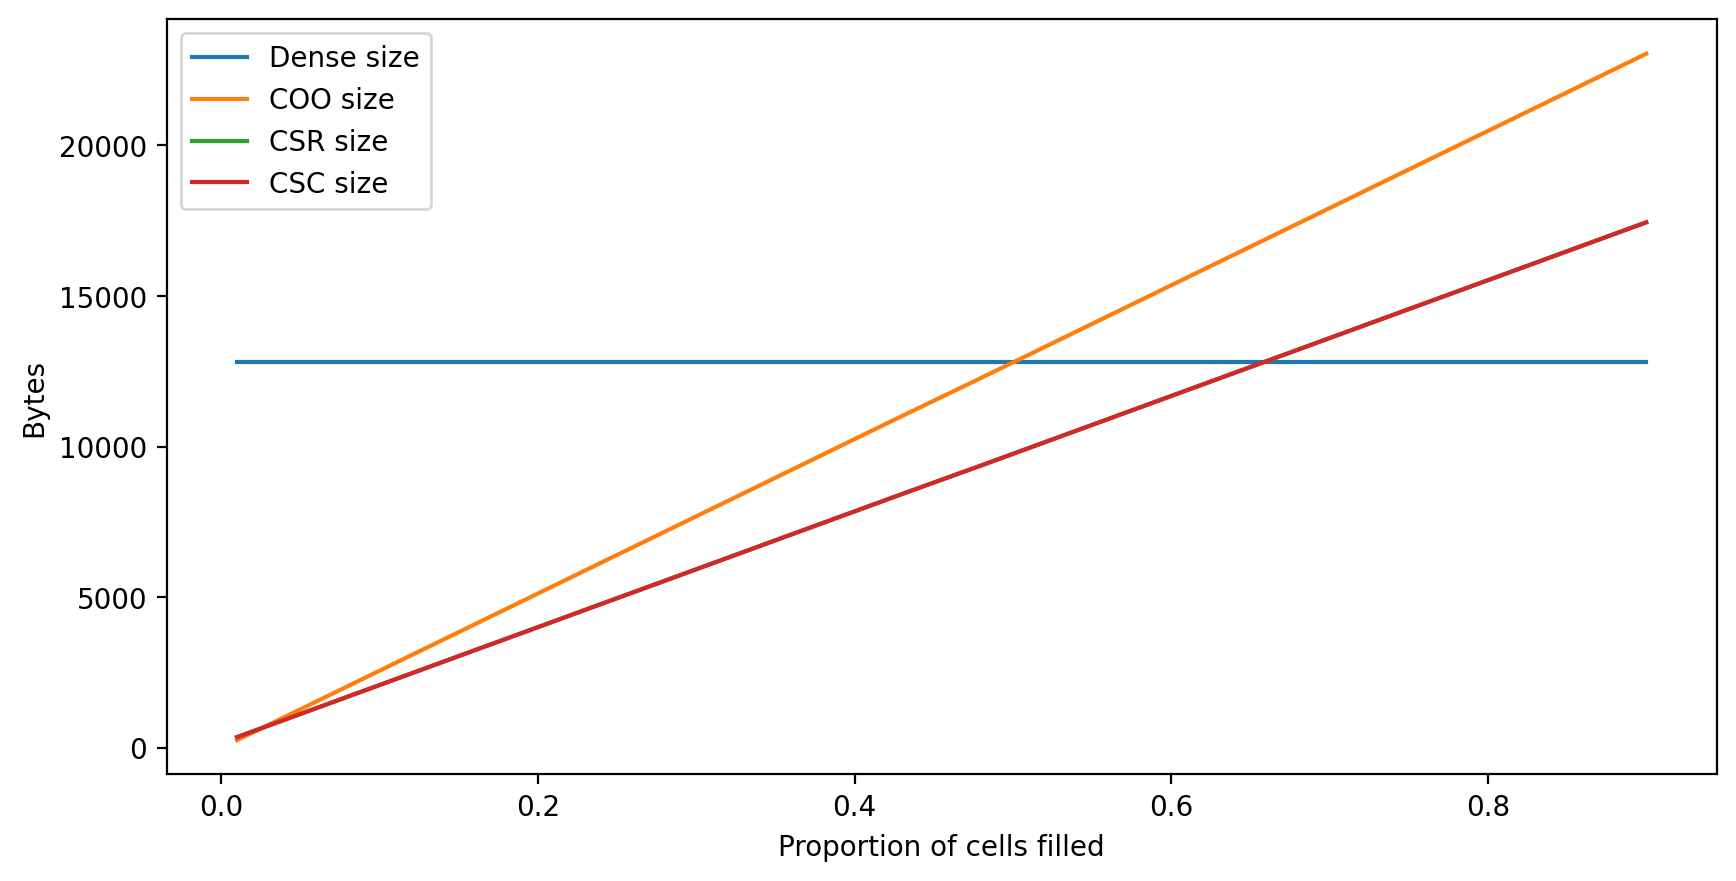

In [110]:
plt.figure(figsize=(10,5), dpi=200)
plt.plot(num_vals, store4[:,0], label='Dense size')
plt.plot(num_vals, store4[:,1], label='COO size')
plt.plot(num_vals, store4[:,2], label='CSR size')
plt.plot(num_vals, store4[:,3], label='CSC size')
#plt.plot(num_vals, store4[:,4], label='LIL size')
#plt.plot(num_vals, store4[:,5], label='DIA size')
#plt.plot(num_vals, store4[:,6], label='DOK size')
#plt.plot(num_vals, store4[:,7], label='BSR size')
#plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.ylabel('Bytes')
plt.xlabel('Proportion of cells filled')